In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

In [2]:
warnings.filterwarnings('ignore')

### Loading the data

In [3]:
thyroid_disease_data = pd.read_csv('../final_project/data/Thyroid-Dataset.csv')

In [4]:
thyroid_disease_data.shape

(9171, 23)

In [5]:
pd.set_option('display.max_columns', None)
thyroid_disease_data.head(10)

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral source,class
0,29,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.6,1.9,128.0,NaN,NaN,other,negative
1,41,F,False,False,False,False,False,False,False,False,True,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,other,negative
2,36,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,other,negative
3,32,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,other,miscellaneous
4,60,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,other,negative
5,77,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,other,negative
6,28,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.7,2.6,116.0,NaN,NaN,SVI,negative
7,28,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.2,1.8,76.0,NaN,NaN,other,negative
8,28,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.9,1.7,83.0,NaN,NaN,other,negative
9,54,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.9,2.3,133.0,NaN,NaN,other,negative


### Data Exploration

#### Check data types

In [6]:
thyroid_disease_data.dtypes

age                            int64
sex                           object
on thyroxine                    bool
query on thyroxine              bool
on antithyroid medication       bool
sick                            bool
pregnant                        bool
thyroid surgery                 bool
I131 treatment                  bool
query hypothyroid               bool
query hyperthyroid              bool
lithium                         bool
goitre                          bool
tumor                           bool
hypopituitary                   bool
psych                           bool
TSH                          float64
T3                           float64
TT4                          float64
T4U                          float64
FTI                          float64
referral source               object
class                         object
dtype: object

#### Check value counts

In [7]:
def generate_value_counts(data: pd.DataFrame) -> str:
    
    for col in data.columns:
        print(data[col].value_counts())

In [8]:
generate_value_counts(thyroid_disease_data)

age
60       209
62       208
72       207
59       201
61       192
        ... 
3          2
455        1
65511      1
65512      1
65526      1
Name: count, Length: 100, dtype: int64
sex
F    6072
M    2792
Name: count, dtype: int64
on thyroxine
False    7931
True     1240
Name: count, dtype: int64
query on thyroxine
False    9018
True      153
Name: count, dtype: int64
on antithyroid medication
False    9055
True      116
Name: count, dtype: int64
sick
False    8827
True      344
Name: count, dtype: int64
pregnant
False    9064
True      107
Name: count, dtype: int64
thyroid surgery
False    9037
True      134
Name: count, dtype: int64
I131 treatment
False    9002
True      169
Name: count, dtype: int64
query hypothyroid
False    8542
True      629
Name: count, dtype: int64
query hyperthyroid
False    8520
True      651
Name: count, dtype: int64
lithium
False    9078
True       93
Name: count, dtype: int64
goitre
False    9087
True       84
Name: count, dtype: int64
tumor
False    

In [9]:
thyroid_disease_data.loc[thyroid_disease_data.age >= 455]

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral source,class
2975,455,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.10,2.0,118.0,1.13,104.0,SVI,negative
5709,65511,M,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.38,2.0,113.0,1.08,104.0,other,negative
6391,65512,M,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0.03,2.8,112.0,0.84,133.0,other,negative
8104,65526,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.50,NaN,132.0,1.02,129.0,other,negative


    There are few invalid values in the age column, but the other columns for these records look correct so instead of removing them we might replace them with another value, e.g. average age. 

#### Check for null values

In [10]:
thyroid_disease_data.isnull().sum()

age                             0
sex                           307
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH                           842
T3                           2603
TT4                           441
T4U                           808
FTI                           801
referral source                 0
class                           0
dtype: int64

    We can also check the proportion of numm values

In [11]:
thyroid_disease_data.isnull().mean().round(4)*100

age                           0.00
sex                           3.35
on thyroxine                  0.00
query on thyroxine            0.00
on antithyroid medication     0.00
sick                          0.00
pregnant                      0.00
thyroid surgery               0.00
I131 treatment                0.00
query hypothyroid             0.00
query hyperthyroid            0.00
lithium                       0.00
goitre                        0.00
tumor                         0.00
hypopituitary                 0.00
psych                         0.00
TSH                           9.18
T3                           28.38
TT4                           4.81
T4U                           8.81
FTI                           8.73
referral source               0.00
class                         0.00
dtype: float64

    There are too many missing values in the T3 column, probably will not be used in the analysis, but this decision requires further investigation.

#### Check the distribution of numerical variables

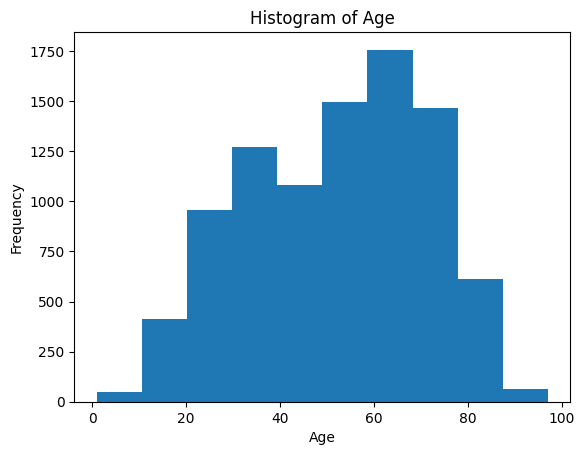

In [12]:
plt.hist(thyroid_disease_data.loc[thyroid_disease_data.age <= 100, 'age'], bins = 10)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Histogram of Age")
plt.show()

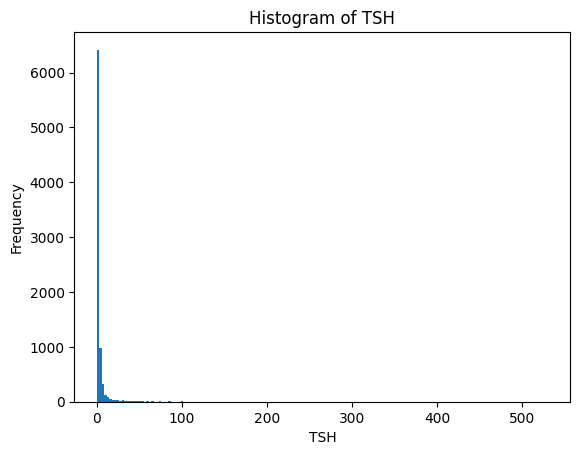

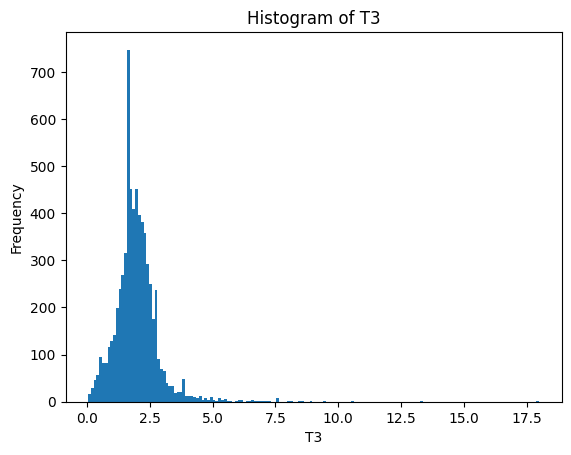

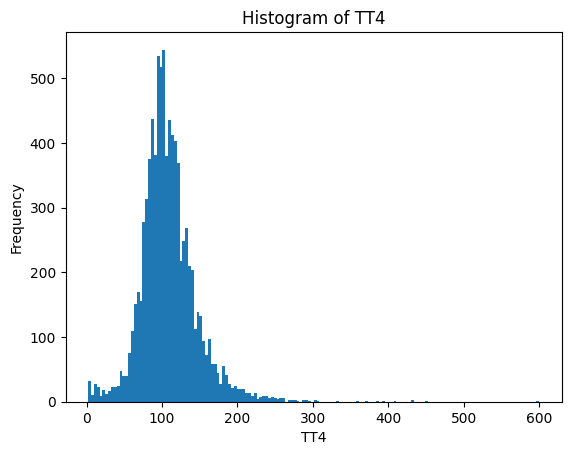

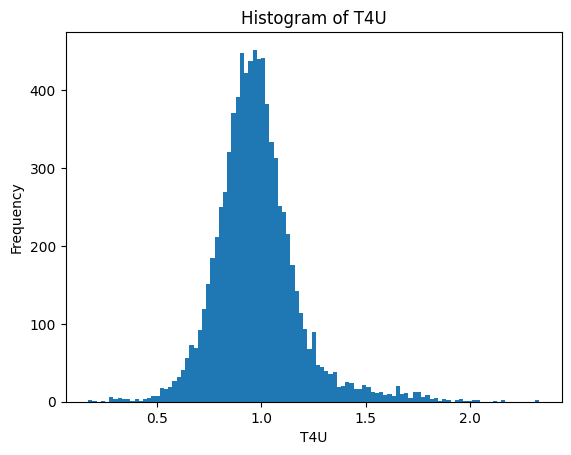

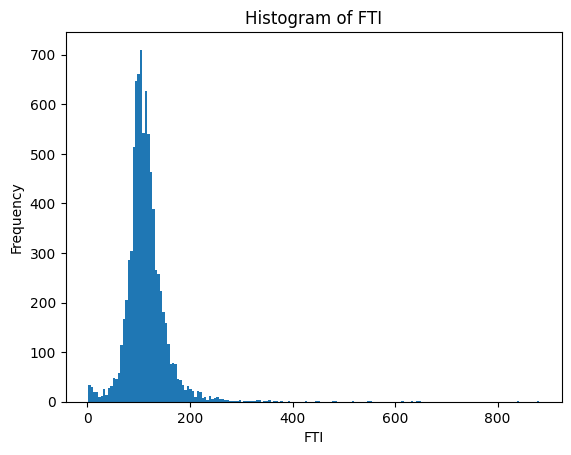

In [13]:
for col in ['TSH', 'T3', 'TT4', 'T4U', 'FTI']:
    plt.hist(thyroid_disease_data[col], bins = 'auto')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col}')
    plt.show()

In [14]:
thyroid_disease_data.TSH.describe()

count    8329.000000
mean        5.218993
std        24.185398
min         0.005000
25%         0.460000
50%         1.400000
75%         2.700000
max       530.000000
Name: TSH, dtype: float64

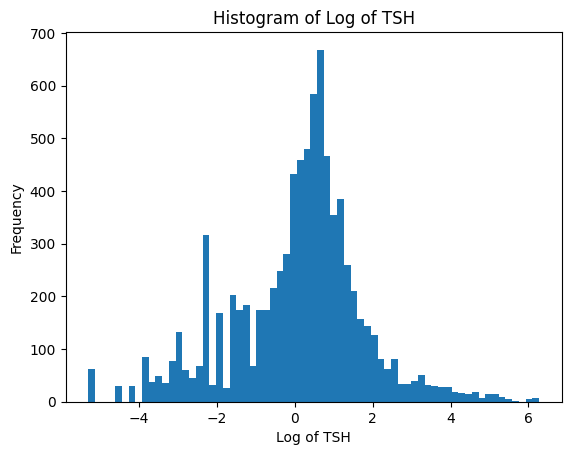

In [15]:
plt.hist(np.log(thyroid_disease_data.TSH), bins = 'auto')
plt.xlabel('Log of TSH')
plt.ylabel('Frequency')
plt.title(f'Histogram of Log of TSH')
plt.show()

#### Check the distribution of the class (target) variable

    We will be intersted in the the presence or absence of hypothyroidism. Hence, we can derive another column from the class column which is 1 if class = hypothyroid conditions and 0 otherwise. Then we are intersted in the distribution of this derived column.

In [16]:
thyroid_disease_data['class'].value_counts(normalize=True)

class
negative                   0.738196
hypothyroid conditions     0.064660
general health             0.061171
binding protein            0.045142
replacement therapy        0.036637
discordant results         0.021481
hyperthyroid conditions    0.019845
miscellaneous              0.009268
antithyroid treatment      0.003598
Name: proportion, dtype: float64

In [17]:
thyroid_disease_data['has_hypothyroidism'] = np.where(thyroid_disease_data['class'] == 'hypothyroid conditions', 1, 0)

In [18]:
thyroid_disease_data['has_hypothyroidism'].value_counts(normalize=True)

has_hypothyroidism
0    0.93534
1    0.06466
Name: proportion, dtype: float64

<Axes: ylabel='proportion'>

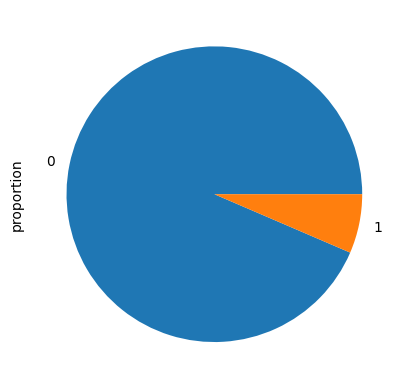

In [19]:
thyroid_disease_data['has_hypothyroidism'].value_counts(normalize=True).plot.pie()

### Data Processing and Cleaning

#### Convert column names to snake case

In [20]:
def convert_to_snake_case(column):
    
    column = column.lower().replace(' ', '_')
    return column


In [21]:
thyroid_disease_data.columns = [convert_to_snake_case(col) for col in thyroid_disease_data.columns]
thyroid_disease_data.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'i131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'tsh', 't3', 'tt4', 't4u',
       'fti', 'referral_source', 'class', 'has_hypothyroidism'],
      dtype='object')

In [22]:
thyroid_disease_data.dtypes

age                            int64
sex                           object
on_thyroxine                    bool
query_on_thyroxine              bool
on_antithyroid_medication       bool
sick                            bool
pregnant                        bool
thyroid_surgery                 bool
i131_treatment                  bool
query_hypothyroid               bool
query_hyperthyroid              bool
lithium                         bool
goitre                          bool
tumor                           bool
hypopituitary                   bool
psych                           bool
tsh                          float64
t3                           float64
tt4                          float64
t4u                          float64
fti                          float64
referral_source               object
class                         object
has_hypothyroidism             int64
dtype: object

#### Convert binary columns to numericsl

In [23]:
bool_cols = thyroid_disease_data.select_dtypes(include = 'bool').columns
thyroid_disease_data[bool_cols] = thyroid_disease_data[bool_cols].astype('int')
thyroid_disease_data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,i131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,tsh,t3,tt4,t4u,fti,referral_source,class,has_hypothyroidism
0,29,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.6,1.9,128.0,NaN,NaN,other,negative,0
1,41,F,0,0,0,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,other,negative,0
2,36,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,other,negative,0
3,32,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,other,miscellaneous,0
4,60,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,other,negative,0


In [24]:
thyroid_disease_data['sex'] = np.where(thyroid_disease_data['sex'] == 'F', 1, 0)

In [25]:
generate_value_counts(thyroid_disease_data)

age
60       209
62       208
72       207
59       201
61       192
        ... 
3          2
455        1
65511      1
65512      1
65526      1
Name: count, Length: 100, dtype: int64
sex
1    6072
0    3099
Name: count, dtype: int64
on_thyroxine
0    7931
1    1240
Name: count, dtype: int64
query_on_thyroxine
0    9018
1     153
Name: count, dtype: int64
on_antithyroid_medication
0    9055
1     116
Name: count, dtype: int64
sick
0    8827
1     344
Name: count, dtype: int64
pregnant
0    9064
1     107
Name: count, dtype: int64
thyroid_surgery
0    9037
1     134
Name: count, dtype: int64
i131_treatment
0    9002
1     169
Name: count, dtype: int64
query_hypothyroid
0    8542
1     629
Name: count, dtype: int64
query_hyperthyroid
0    8520
1     651
Name: count, dtype: int64
lithium
0    9078
1      93
Name: count, dtype: int64
goitre
0    9087
1      84
Name: count, dtype: int64
tumor
0    8930
1     241
Name: count, dtype: int64
hypopituitary
0    9169
1       2
Name: count, dtyp

#### Replace wrong Age data with the average Age

In [26]:
thyroid_disease_data.age = np.where(thyroid_disease_data.age > 100, np.mean(thyroid_disease_data.age), thyroid_disease_data.age)

In [27]:
thyroid_disease_data.age.value_counts()

age
60.0    209
62.0    208
72.0    207
59.0    201
61.0    192
       ... 
97.0      3
95.0      3
9.0       2
5.0       2
3.0       2
Name: count, Length: 97, dtype: int64

#### Missing value imputation

    Before chosing a method for missing value imputation, we want to understand if the data is missing at random or there is a pattern. I will start by exploring the relationship between the missing values in the given column and the variable class, which will be subsequently used as a target variable (after some processing).

In [28]:
non_missing = pd.DataFrame(thyroid_disease_data.loc[~thyroid_disease_data.t3.isnull(), 'class'].value_counts(normalize=True))
non_missing

,proportion
class,
negative,0.725030
general health,0.083892
hypothyroid conditions,0.065317
binding protein,0.041565
replacement therapy,0.030451
discordant results,0.026492
hyperthyroid conditions,0.022229
antithyroid treatment,0.005024


In [29]:
missing = pd.DataFrame(thyroid_disease_data.loc[thyroid_disease_data.t3.isnull(), 'class'].value_counts(normalize=True))
missing

,proportion
class,
negative,0.771418
hypothyroid conditions,0.063004
binding protein,0.054168
replacement therapy,0.052247
miscellaneous,0.032655
hyperthyroid conditions,0.013830
discordant results,0.008836
general health,0.003842


In [30]:
combined = pd.merge(non_missing, missing, left_index = True, right_index = True)
combined

,proportion_x,proportion_y
class,,
negative,0.725030,0.771418
general health,0.083892,0.003842
hypothyroid conditions,0.065317,0.063004
binding protein,0.041565,0.054168
replacement therapy,0.030451,0.052247
discordant results,0.026492,0.008836
hyperthyroid conditions,0.022229,0.013830


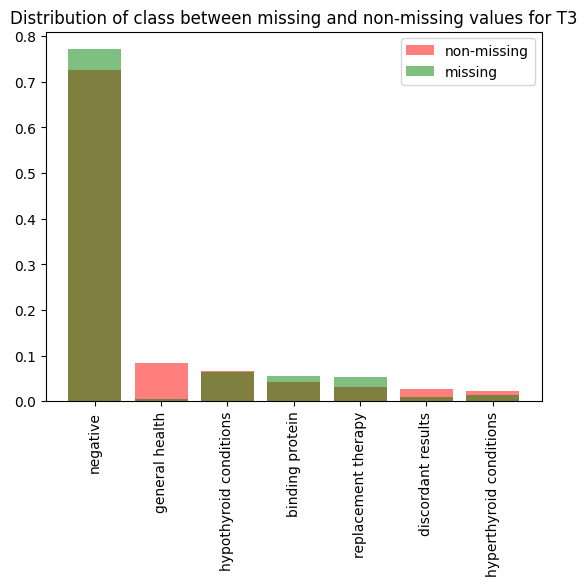

In [31]:
plt.bar(combined.index, combined.proportion_x, alpha = 0.5, color = 'r', label='non-missing')
plt.bar(combined.index, combined.proportion_y, alpha = 0.5, color = 'g', label='missing')
ax = plt.gca()
ax.set_xticklabels(combined.index, rotation=90)
plt.title("Distribution of class between missing and non-missing values for T3")
plt.legend()
plt.show()

    There is a difference between the two distributions, for example there are almost no cases with value 'general health' when the T3 is missing. But we will be interested in predicting hypothyroidism and the relative frequency of hypothyroid condition is the same among observations with missing and non-missing T3. Given that, I assume that it is safe to impute the missing values with the mean. 

    Let's do the same for the other four columns with missing values, namely TSH, TT4, T4U and FTI. 

In [32]:
def check_distribution(col_with_missing_values: str) -> None:
    
    non_missing = pd.DataFrame(thyroid_disease_data.loc[~thyroid_disease_data[col_with_missing_values].isnull(), 'class'].value_counts(normalize=True))
    missing = pd.DataFrame(thyroid_disease_data.loc[thyroid_disease_data[col_with_missing_values].isnull(), 'class'].value_counts(normalize=True))
    combined = pd.merge(non_missing, missing, left_index = True, right_index = True)
    
    plt.bar(combined.index, combined.proportion_x, alpha = 0.5, color = 'r', label='non-missing')
    plt.bar(combined.index, combined.proportion_y, alpha = 0.5, color = 'g', label='missing')
    ax = plt.gca()
    ax.set_xticklabels(combined.index, rotation=90)
    plt.title(f"Distribution of class between missing and non-missing values for {col_with_missing_values.upper()}")
    plt.legend()
    plt.show()

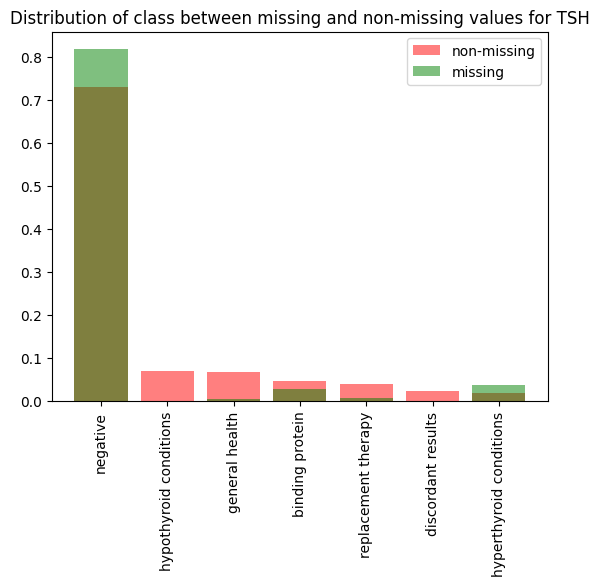

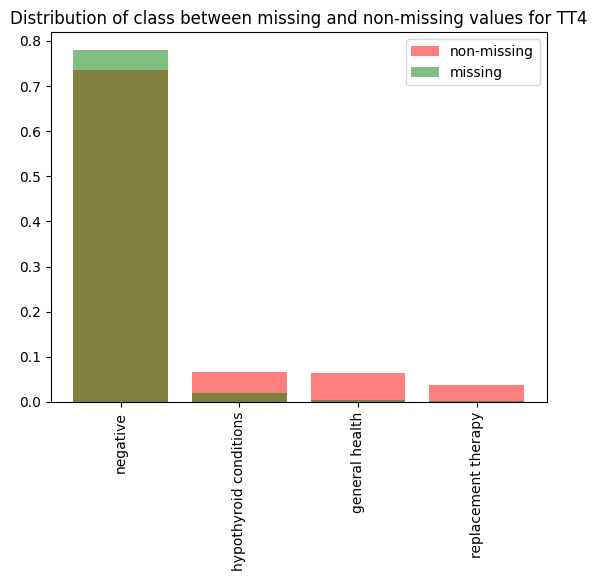

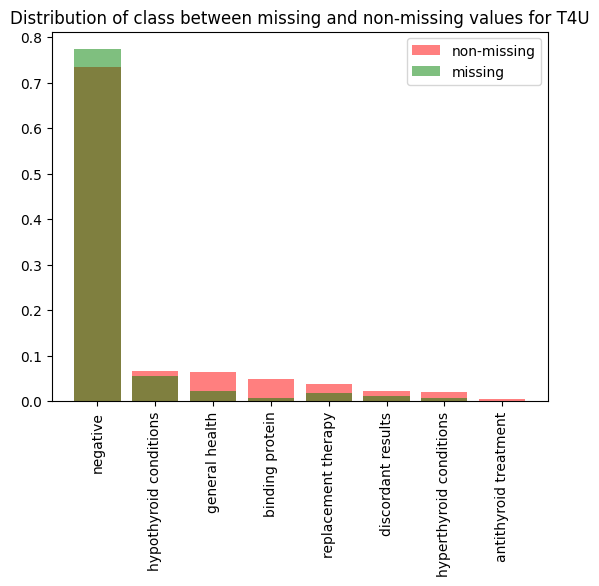

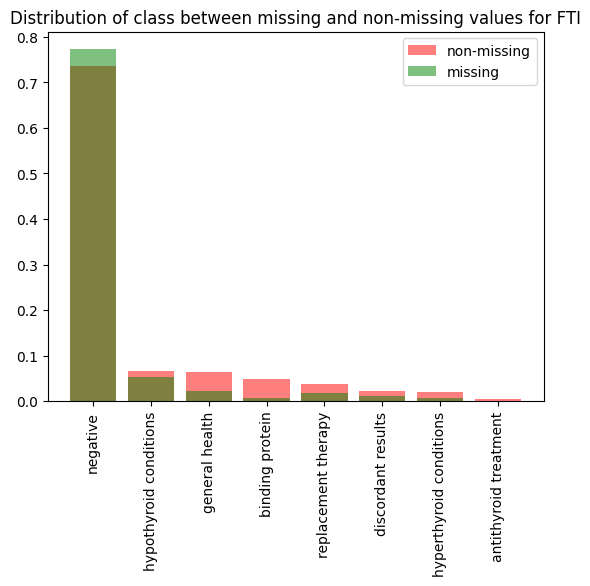

In [33]:
for col in ['tsh', 'tt4', 't4u', 'fti']:
    check_distribution(col)

    The proportion of hypothyroid condition within records with missing and non-missing values for TSH and TT4 is very different which means that replacing them with the average value might lead to decreased model performance. The other options are to either not use these two columns in the machine laerning model or impute them with a value which is different from all other values, so that these records remain in the dataset but also remain different from all other records. Given that the hypothyroid condition exists only for 6% of the records, it might be that records with missing values for TSH and TT4 don't have a hypothyroid condition purely by change, gut we cannot be sure so for now will continue to explore the option that the fact that the values are missing might have a discriminative power.

    At the same time I think that the missing values in the T4U and FTI columns can be replaced with the mean.

In [34]:
def missing_value_imputation(dataset: pd.DataFrame, col_with_missing_value: str, substitue_value: float) -> pd.DataFrame:
    
    dataset[col_with_missing_value] = np.where(dataset[col_with_missing_value].isnull(), substitue_value, dataset[col_with_missing_value])
    return dataset

In [35]:
thyroid_disease_data = missing_value_imputation(thyroid_disease_data, 't4u', np.mean(thyroid_disease_data.t4u))
thyroid_disease_data = missing_value_imputation(thyroid_disease_data, 'fti', np.mean(thyroid_disease_data.fti))
thyroid_disease_data = missing_value_imputation(thyroid_disease_data, 't3', np.mean(thyroid_disease_data.t3))

In [36]:
thyroid_disease_data[['t4u', 't3', 'fti']].isnull().sum()

t4u    0
t3     0
fti    0
dtype: int64

### Exploratory Data Analysis

#### Check the relationship between the target and the categorical variables

    We can do this by applying a chi-square test of independence

In [37]:
dataset_categorical = thyroid_disease_data.select_dtypes(include='int')
pairs = list(itertools.combinations(dataset_categorical.columns, 2))
output_df = pd.DataFrame(columns=['first_col', 'second_col', 'chi_square_stat', 'p_value'])

for pair in pairs:
    contingency_table = pd.crosstab(dataset_categorical[pair[0]], dataset_categorical[pair[1]])
    chi2_stat, p_val  = chi2_contingency(contingency_table)[:2]

    if p_val <= 0.1:
        new_row = pd.DataFrame({'first_col': [pair[0]], 'second_col': [pair[1]], 'chi_square_stat': [chi2_stat], 'p_value': [p_val]})
        output_df = pd.concat([output_df, new_row], ignore_index=True)

    output_df = output_df.sort_values(by = ['first_col', 'second_col'])

output_df.loc[(output_df['first_col'] == 'has_hypothyroidism') | (output_df['second_col'] == 'has_hypothyroidism')]

,first_col,second_col,chi_square_stat,p_value
0,goitre,has_hypothyroidism,4.831279,2.794789e-02
11,on_thyroxine,has_hypothyroidism,46.099695,1.123860e-11
18,pregnant,has_hypothyroidism,6.441603,1.114780e-02
51,psych,has_hypothyroidism,14.227687,1.619698e-04
26,query_hypothyroid,has_hypothyroidism,54.214470,1.797583e-13
32,sex,has_hypothyroidism,16.233351,5.599955e-05
43,sick,has_hypothyroidism,2.994153,8.356560e-02


    There are a few variables which show a potentially strong relationship with the target variable. Let's also explore the relationship of the target with the numerical features.

#### Check the relationship between the target and the numerical variables**

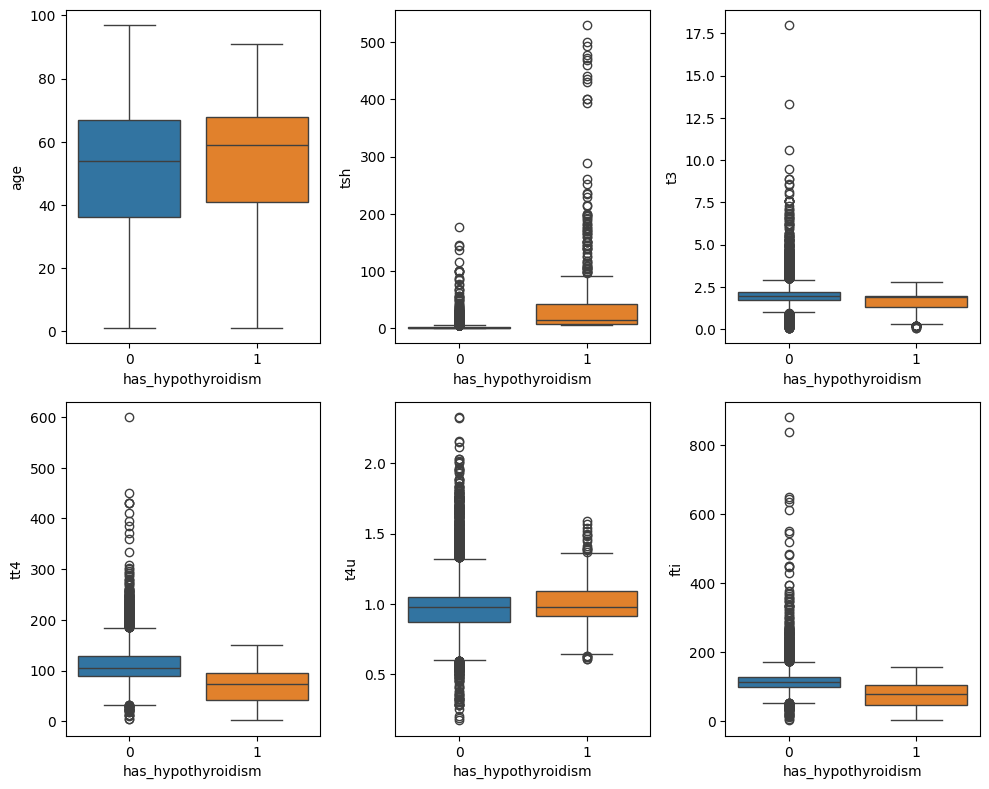

In [38]:
fig= plt.figure(figsize=(10,8))
custom_palette = sns.color_palette()
i = 1

for col in ['age', 'tsh', 't3', 'tt4', 't4u', 'fti']:
    fig.add_subplot(2,3,i)
    sns.boxplot(x=thyroid_disease_data["has_hypothyroidism"], y=thyroid_disease_data[col], palette=custom_palette)
    i+=1

plt.tight_layout()
plt.show()


    Potentially the TSH, T3, TT4 and FTI have a strong relationship with the target variable. Let's explore the correlation as well.

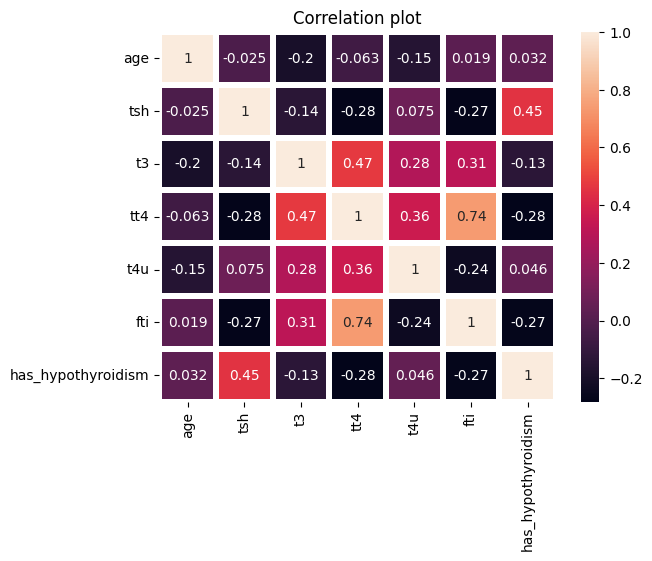

In [39]:
dataset_num = thyroid_disease_data.select_dtypes(include='float')
dataset_num = pd.merge(dataset_num, thyroid_disease_data['has_hypothyroidism'], left_index=True, right_index=True)

corr_plot = sns.heatmap(dataset_num.corr(), annot = True, linewidths=3 )
plt.title("Correlation plot")
plt.show()

    We again see that TSH has the biggest linear relationship with the target. But we also see that some of the features are highly correlated, for example T3 and TT4, TT4 and FTI, potentially TT4 and T4U. This means that if we include all of the in the model we will introduce multicollinearity which will deteriorate the model performance on unseen data. This needs to be considered when building the model.

### Model Building

#### Train-Test Split